In [14]:
# PyTorch and PyTorch Geometric imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import torch_geometric.utils as pyg_utils
from torch_geometric.utils import from_networkx

# NetworkX imports
import networkx as nx
from networkx.algorithms.centrality import betweenness_centrality

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

# Other imports
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import random

# Custom imports
from Datasets.synthetics import BA_2grid, BA_2grid_house, ProbingDataset, BA_2grid_to_test
from models.models_BA_2grid import GIN_framework as framework

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def set_seed(seed):
    if seed == -1:
        seed = random.randint(0, 1000)
    # Pandas also uses np random state by default
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    # if you are using GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [4]:
set_seed(43)

Model

In [5]:
MODEL = "GIN"
DATASET = "BA_2grid_house"

# import the model
from models.models_BA_2grid_house import GIN_framework3 as framework
# import the dataset
from Datasets.synthetics import BA_2grid_house

In [6]:
# inizialize the framework
dataset = BA_2grid_house()
gnn = framework(dataset,device="cpu")

c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\data\in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [7]:
# the gnn object contains the train test split and the model.

print(gnn.model)
print(gnn.train_idx)
print(gnn.dataset[gnn.train_idx])

Net(
  (mlp1): Linear(in_features=10, out_features=30, bias=True)
  (conv1): GINConv(nn=Linear(in_features=10, out_features=30, bias=True))
  (mlp2): Linear(in_features=30, out_features=30, bias=True)
  (conv2): GINConv(nn=Linear(in_features=30, out_features=30, bias=True))
  (lin1): Linear(in_features=30, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=2, bias=True)
)
tensor([ 701, 1225,   47,  ...,   40,  423,  494])
BA_2grid_house(1600)


In [8]:
#now that the model is instaziated, we have to load the weights
gnn.load_model("models/"+DATASET+"_"+MODEL)
print("we loaded the weights")
# right now the model has trained weights.
# print(gnn.model.mlp1.weight[0])

we loaded the weights


In [9]:
# train the model
gnn.evaluate()

Test Loss: 0.035, Train Acc: 0.971 Test Acc: 0.973


Properties of the graphs

In [ ]:
import networkx as nx

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = nx.average_shortest_path_length(G) if nx.is_connected(G) else None
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_node_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        #small_world = nx.algorithms.smallworld.sigma(G)

        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_node_in_the_largest_fully_connected_component)) #, small_world))
    return properties

train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])


In [14]:
#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
    pkl.dump(train_properties, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
    pkl.dump(test_properties, f)

In [16]:
#open the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [17]:
len(test_properties)

400

### Probing pipeline 

from extracting features to training a diagnostic classifier

In [18]:
train_features, test_features = gnn.evaluate_with_features2()

In [19]:
len(train_features), len(test_features)

(1600, 400)

In [20]:
len(train_features[0])

5

#### Diagnostic classifier

In [18]:
"""
The embeddings of GIN are like this:
return F.log_softmax(out, dim=-1), (x1, x2, x_global, x_lin1, out)
"""

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x_global = np.array([feat[2] for feat in train_features])
test_x_global = np.array([feat[2] for feat in test_features])

train_xlin = np.array([feat[3] for feat in train_features])
test_xlin = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

# Compute graph properties
train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_xlin = torch.tensor(train_xlin, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_xlin = torch.tensor(test_xlin, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x_global, test_x_global), (train_xlin, test_xlin), (train_x5, test_x5)]
embeddings_names = ['x', 'x2', 'x_global', 'x_lin1', 'x5']


Epoch [1000/10000], Property: num_nodes, Loss: 398.8685
Epoch [2000/10000], Property: num_nodes, Loss: 255.9386
Epoch [3000/10000], Property: num_nodes, Loss: 155.1484
Epoch [4000/10000], Property: num_nodes, Loss: 88.3326
Epoch [5000/10000], Property: num_nodes, Loss: 48.0187
Epoch [6000/10000], Property: num_nodes, Loss: 27.1663
Epoch [7000/10000], Property: num_nodes, Loss: 18.6172
Epoch [8000/10000], Property: num_nodes, Loss: 15.2758
Epoch [9000/10000], Property: num_nodes, Loss: 13.0877
Epoch [10000/10000], Property: num_nodes, Loss: 11.2438
Embedding: torch.Size([1600, 30])
Property: num_nodes
  Train MSE: 11.2422, Test MSE: 10.2502
  Train R²: -0.3613, Test R²: -0.2737
Epoch [1000/10000], Property: num_edges, Loss: 564.8271
Epoch [2000/10000], Property: num_edges, Loss: 387.4129
Epoch [3000/10000], Property: num_edges, Loss: 254.2403
Epoch [4000/10000], Property: num_edges, Loss: 158.2383
Epoch [5000/10000], Property: num_edges, Loss: 93.3250
Epoch [6000/10000], Property: num_e

In [ ]:

#create a dictionary where we will sotre the results for each embeddings, each property
results = {}
ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 10000  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embdedding = embeddings_names[ii]
            results[(name_of_embdedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1


#save the results in a file
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "wb") as f:
    pkl.dump(results, f)

In [ ]:
#load the results
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "rb") as f:
    results = pkl.load(f)

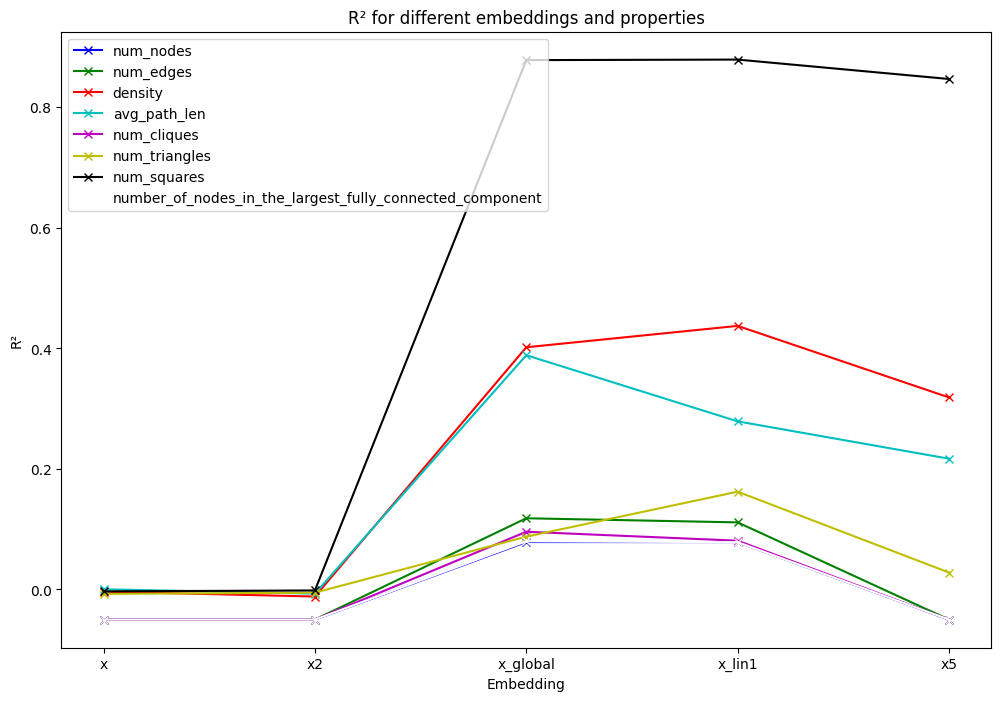

In [20]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings_names = ['x', 'x2', 'x_global', 'x_lin1', 'x5']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('R² for different embeddings and properties')
plt.show()


### comparison with a gnn train on random (the y are shuffled)

In [1]:
### comparison with a gnn train on random (the y are shuffled)

MODEL = "GIN"
DATASET = "BA_2grid_house_shuffled"

# import the model
from models.models_BA_2grid_house import GIN_framework3 as framework
# import the dataset
from Datasets.synthetics import BA_2grid_house


In [2]:
# inizialize the framework
dataset = BA_2grid_house()

In [3]:
dataset[0].y

tensor([0])

In [4]:
#shuffle the y values of the dataset
import numpy as np
import torch

y = np.array([data.y for data in dataset])

# Assuming y is a list or numpy array
y = np.array(y, dtype=np.int64)  # Ensure y is a numeric array of type int64

# Shuffle y
np.random.shuffle(y)

# Convert y to a PyTorch tensor with dtype torch.int64
y = torch.tensor(y, dtype=torch.int64)

# Update dataset with the new y values
for i in range(len(dataset)):
    dataset[i].y = y[i]

/scratch-local/tpelletreaudur.7482777/ipykernel_2282745/4169330594.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y = np.array([data.y for data in dataset])
/scratch-local/tpelletreaudur.7482777/ipykernel_2282745/4169330594.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array([data.y for data in dataset])


In [5]:
dataset[0].y

tensor([0])

In [6]:
gnn = framework(dataset)

/home/tpelletreaudur/.local/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [7]:
gnn.iterate()

Epoch: 020, Loss: 0.427, Test Loss: 0.110, Train Acc: 0.848 Test Acc: 0.820
Epoch: 040, Loss: 0.267, Test Loss: 0.072, Train Acc: 0.902 Test Acc: 0.887
Epoch: 060, Loss: 0.183, Test Loss: 0.047, Train Acc: 0.943 Test Acc: 0.948
Epoch: 080, Loss: 0.131, Test Loss: 0.033, Train Acc: 0.975 Test Acc: 0.970
Epoch: 100, Loss: 0.099, Test Loss: 0.024, Train Acc: 0.989 Test Acc: 0.993
Epoch: 120, Loss: 0.080, Test Loss: 0.019, Train Acc: 0.993 Test Acc: 0.995
Epoch: 140, Loss: 0.067, Test Loss: 0.016, Train Acc: 0.994 Test Acc: 0.998
Epoch: 160, Loss: 0.058, Test Loss: 0.013, Train Acc: 0.994 Test Acc: 0.998
Epoch: 180, Loss: 0.051, Test Loss: 0.012, Train Acc: 0.995 Test Acc: 0.998
Epoch: 200, Loss: 0.045, Test Loss: 0.010, Train Acc: 0.995 Test Acc: 0.998


In [8]:
#save the model 
gnn.save_model(path="models/"+DATASET+"_"+MODEL+".pt")
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+".pt")

model saved in:  models/BA_2grid_house_shuffled_GIN.pt


In [9]:
gnn.evaluate()

Test Loss: 0.010, Train Acc: 0.995 Test Acc: 0.998


In [10]:
import networkx as nx
def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the average path length of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = calculate_avg_path_length(G)
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_node_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        #small_world = nx.algorithms.smallworld.sigma(G)

        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_node_in_the_largest_fully_connected_component)) #, small_world))
    return properties

train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

In [11]:
import pickle as pkl
#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
    pkl.dump(train_properties, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
    pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [12]:
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=False)

In [15]:
"""
The embeddings of GIN are like this:
return F.log_softmax(out, dim=-1), (x1, x2, x_global, x_lin1, out)
"""


output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x_global = np.array([feat[2] for feat in train_features])
test_x_global = np.array([feat[2] for feat in test_features])

train_xlin = np.array([feat[3] for feat in train_features])
test_xlin = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

# Compute graph properties
train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_xlin = torch.tensor(train_xlin, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_xlin = torch.tensor(test_xlin, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x_global, test_x_global), (train_xlin, test_xlin), (train_x5, test_x5)]
embeddings_names = ['x', 'x2', 'x_global', 'x_lin1', 'x5']


In [16]:
#create a dictionary where we will sotre the results for each embeddings, each property
results = {}
ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 10000  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embdedding = embeddings_names[ii]
            results[(name_of_embdedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1


#save the results in a file
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "wb") as f:
    pkl.dump(results, f)

Epoch [1000/10000], Property: num_nodes, Loss: 401.5229
Epoch [2000/10000], Property: num_nodes, Loss: 251.8016
Epoch [3000/10000], Property: num_nodes, Loss: 147.8224
Epoch [4000/10000], Property: num_nodes, Loss: 80.6865
Epoch [5000/10000], Property: num_nodes, Loss: 42.6483
Epoch [6000/10000], Property: num_nodes, Loss: 25.4714
Epoch [7000/10000], Property: num_nodes, Loss: 19.8295
Epoch [8000/10000], Property: num_nodes, Loss: 17.8011
Epoch [9000/10000], Property: num_nodes, Loss: 16.0991
Epoch [10000/10000], Property: num_nodes, Loss: 14.4200
Embedding: torch.Size([1600, 30])
Property: num_nodes
  Train MSE: 14.4184, Test MSE: 13.7143
  Train R²: -0.7459, Test R²: -0.7041
Epoch [1000/10000], Property: num_edges, Loss: 542.0140
Epoch [2000/10000], Property: num_edges, Loss: 361.7274
Epoch [3000/10000], Property: num_edges, Loss: 229.1773
Epoch [4000/10000], Property: num_edges, Loss: 136.4142
Epoch [5000/10000], Property: num_edges, Loss: 76.8752
Epoch [6000/10000], Property: num_e

Epoch [4000/10000], Property: avg_path_len, Loss: 0.3541
Epoch [5000/10000], Property: avg_path_len, Loss: 0.2618
Epoch [6000/10000], Property: avg_path_len, Loss: 0.2489
Epoch [7000/10000], Property: avg_path_len, Loss: 0.2479
Epoch [8000/10000], Property: avg_path_len, Loss: 0.2472
Epoch [9000/10000], Property: avg_path_len, Loss: 0.2463
Epoch [10000/10000], Property: avg_path_len, Loss: 0.2455
Embedding: torch.Size([1600, 30])
Property: avg_path_len
  Train MSE: 0.2455, Test MSE: 0.2494
  Train R²: -0.0053, Test R²: -0.0142
Epoch [1000/10000], Property: num_cliques, Loss: 236.6024
Epoch [2000/10000], Property: num_cliques, Loss: 115.1168
Epoch [3000/10000], Property: num_cliques, Loss: 95.3516
Epoch [4000/10000], Property: num_cliques, Loss: 87.1805
Epoch [5000/10000], Property: num_cliques, Loss: 78.4068
Epoch [6000/10000], Property: num_cliques, Loss: 68.9853
Epoch [7000/10000], Property: num_cliques, Loss: 59.1551
Epoch [8000/10000], Property: num_cliques, Loss: 49.3303
Epoch [90

Epoch [6000/10000], Property: num_squares, Loss: 0.0069
Epoch [7000/10000], Property: num_squares, Loss: 0.0067
Epoch [8000/10000], Property: num_squares, Loss: 0.0066
Epoch [9000/10000], Property: num_squares, Loss: 0.0064
Epoch [10000/10000], Property: num_squares, Loss: 0.0062
Embedding: torch.Size([1600, 30])
Property: num_squares
  Train MSE: 0.0062, Test MSE: 0.0064
  Train R²: 0.8710, Test R²: 0.8730
Epoch [1000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 164.9604
Epoch [2000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 31.4805
Epoch [3000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.4021
Epoch [4000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 9.3349
Epoch [5000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 9.0989
Epoch [6000/10000], Property: number_of_nodes_in_the_largest_fully_connected_com

Epoch [1000/10000], Property: num_edges, Loss: 698.8047
Epoch [2000/10000], Property: num_edges, Loss: 606.5760
Epoch [3000/10000], Property: num_edges, Loss: 522.4847
Epoch [4000/10000], Property: num_edges, Loss: 445.7941
Epoch [5000/10000], Property: num_edges, Loss: 376.0590
Epoch [6000/10000], Property: num_edges, Loss: 313.0156
Epoch [7000/10000], Property: num_edges, Loss: 256.4956
Epoch [8000/10000], Property: num_edges, Loss: 206.3729
Epoch [9000/10000], Property: num_edges, Loss: 162.5311
Epoch [10000/10000], Property: num_edges, Loss: 124.8441
Embedding: torch.Size([1600, 2])
Property: num_edges
  Train MSE: 124.8094, Test MSE: 124.0639
  Train R²: -10.6320, Test R²: -10.3601
Epoch [1000/10000], Property: density, Loss: 0.0007
Epoch [2000/10000], Property: density, Loss: 0.0003
Epoch [3000/10000], Property: density, Loss: 0.0003
Epoch [4000/10000], Property: density, Loss: 0.0003
Epoch [5000/10000], Property: density, Loss: 0.0003
Epoch [6000/10000], Property: density, Loss:

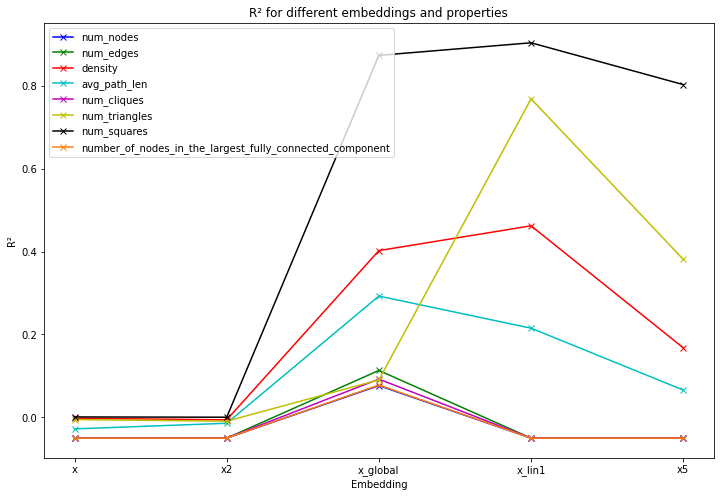

<Figure size 432x288 with 0 Axes>

In [17]:
#load results 
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "rb") as f:
    results = pkl.load(f)
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings_names = ['x', 'x2', 'x_global', 'x_lin1', 'x5']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'_test_R2_plot.png', dpi=300, bbox_inches='tight')

### Node embedding probing

This time we will try to probe for node embedding learnt representations. What would make sense is that the GNN uses some node characteristics like the betweeness centrality of some nodes to predict if a graph could contain both a grid and a house. 

##### Node properties

In [19]:
# Define function to compute node-level properties
def compute_node_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        node_degrees = list(dict(G.degree()).values())
        clustering_coeffs = list(nx.clustering(G).values())
        betweenness_centralities = list(nx.betweenness_centrality(G).values())
        eigenvector_centralities = list(nx.eigenvector_centrality(G, max_iter=10000).values())
        Local_clustering_coefficients = list(nx.clustering(G).values())

        properties.append((node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, Local_clustering_coefficients))
    return properties

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties(gnn.dataset[gnn.train_idx])
test_node_properties = compute_node_properties(gnn.dataset[gnn.test_idx])

#train_node_properties is a list of tuples, where each tuple contains 5 lists, each list contains the node-level property for each node in the graph

##### Node embeddings

In [11]:
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=True)

len of features:  2
features[0].shape:  torch.Size([25, 30])
features[1].shape:  torch.Size([25, 30])
train_features[0][0].shape:  (25, 30)
len of features:  2
features[0].shape:  torch.Size([27, 30])
features[1].shape:  torch.Size([27, 30])
train_features[0][0].shape:  (25, 30)
len of features:  2
features[0].shape:  torch.Size([27, 30])
features[1].shape:  torch.Size([27, 30])
train_features[0][0].shape:  (25, 30)
len of features:  2
features[0].shape:  torch.Size([25, 30])
features[1].shape:  torch.Size([25, 30])
train_features[0][0].shape:  (25, 30)
len of features:  2
features[0].shape:  torch.Size([29, 30])
features[1].shape:  torch.Size([29, 30])
train_features[0][0].shape:  (25, 30)
len of features:  2
features[0].shape:  torch.Size([29, 30])
features[1].shape:  torch.Size([29, 30])
train_features[0][0].shape:  (25, 30)
len of features:  2
features[0].shape:  torch.Size([24, 30])
features[1].shape:  torch.Size([24, 30])
train_features[0][0].shape:  (25, 30)
len of features:  2


In [12]:
len(train_features), len(test_features)

(1600, 400)

In [13]:
# Check the shape of the first graph's features
first_graph_features = train_features[1]
for i, feature in enumerate(first_graph_features):
    print(f"Feature {i+1} shape:", feature.shape)

Feature 1 shape: (27, 30)
Feature 2 shape: (27, 30)


In [14]:
train_features[1][0][26]

array([0.        , 0.        , 0.        , 0.        , 0.47454751,
       0.        , 0.40765282, 0.2851614 , 0.26304904, 0.        ,
       0.        , 0.22247813, 0.08886687, 0.07335069, 0.        ,
       0.13493093, 0.        , 0.        , 0.31370571, 0.        ,
       0.10270742, 0.        , 0.        , 0.2535243 , 0.        ,
       0.36614835, 0.        , 0.46745601, 0.        , 0.        ])

#### Embedding probing

##### Probing for the top 3 nodes on train_features only and averaging the results of the different diagnostif classifiers

In [15]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Function to get the top 3 nodes based on a specific property
def get_top_nodes(property_list, top_n=3):
    sorted_indices = sorted(range(len(property_list)), key=lambda k: property_list[k], reverse=True)
    return sorted_indices[:top_n]

In [20]:

# Get the top 3 nodes for local clustering coefficient and eigenvector centrality
top_nodes_local_clustering = [get_top_nodes(graph_props[3], 3) for graph_props in train_node_properties]  # Assuming 3rd index is for local clustering coefficient
top_nodes_eigenvector = [get_top_nodes(graph_props[4], 3) for graph_props in train_node_properties]  # Assuming 4th index is for eigenvector centrality


In [17]:
# Prepare the data for linear regression model training
def prepare_regression_data(features, properties, top_nodes_indices):
    X = []
    y = []
    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices[i]:
                X.append(graph_features[layer][node_index])
                y.append(properties[i][node_index])
    return torch.tensor(X), torch.tensor(y)

# Training and evaluating linear regression models
def train_and_evaluate_regression(X, y):
    model = LinearModel(X.shape[1], 1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    model.train()
    for epoch in range(1000):
        optimizer.zero_grad()
        outputs = model(X.float())
        loss = criterion(outputs, y.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X.float()).view(-1)
        r2 = r2_score(y.float(), predictions)
    return r2

In [21]:

# Prepare data for local clustering coefficient regression
X_local_clustering, y_local_clustering = prepare_regression_data(train_features, [props[3] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for local clustering coefficient
r2_local_clustering = train_and_evaluate_regression(X_local_clustering, y_local_clustering)
print(f'R² for local clustering coefficient prediction: {r2_local_clustering}')

# Prepare data for eigenvector centrality regression
X_eigenvector, y_eigenvector = prepare_regression_data(train_features, [props[4] for props in train_node_properties], top_nodes_eigenvector)

# Train and evaluate model for eigenvector centrality
r2_eigenvector = train_and_evaluate_regression(X_eigenvector, y_eigenvector)
print(f'R² for eigenvector centrality prediction: {r2_eigenvector}')

# Prepare data for node degree regression
X_node_degree, y_node_degree = prepare_regression_data(train_features, [props[0] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for node degree
r2_node_degree = train_and_evaluate_regression(X_node_degree, y_node_degree)
print(f'R² for node degree prediction: {r2_node_degree}')

# Prepare data for betweenness centrality regression
X_betweenness, y_betweenness = prepare_regression_data(train_features, [props[2] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for betweenness centrality
r2_betweenness = train_and_evaluate_regression(X_betweenness, y_betweenness)
print(f'R² for betweenness centrality prediction: {r2_betweenness}')


C:\Users\tomdu\AppData\Local\Temp\ipykernel_18336\1256878820.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(X), torch.tensor(y)


Epoch 0, Loss: 0.2586923837661743
Epoch 10, Loss: 0.03575789928436279
Epoch 20, Loss: 0.023039551451802254
Epoch 30, Loss: 0.01370225753635168
Epoch 40, Loss: 0.009970486164093018
Epoch 50, Loss: 0.008345568552613258
Epoch 60, Loss: 0.007481980137526989
Epoch 70, Loss: 0.006914941594004631
Epoch 80, Loss: 0.0065911198034882545
Epoch 90, Loss: 0.006325897295027971
Epoch 100, Loss: 0.00613279826939106
Epoch 110, Loss: 0.005977921653538942
Epoch 120, Loss: 0.005860601551830769
Epoch 130, Loss: 0.005771338008344173
Epoch 140, Loss: 0.00570201501250267
Epoch 150, Loss: 0.005647839512676001
Epoch 160, Loss: 0.005604506470263004
Epoch 170, Loss: 0.005568921100348234
Epoch 180, Loss: 0.0055388715118169785
Epoch 190, Loss: 0.005512807983905077
Epoch 200, Loss: 0.005489674396812916
Epoch 210, Loss: 0.005468767136335373
Epoch 220, Loss: 0.005449625197798014
Epoch 230, Loss: 0.005431950557976961
Epoch 240, Loss: 0.005415548104792833
Epoch 250, Loss: 0.0054002865217626095
Epoch 260, Loss: 0.0053860

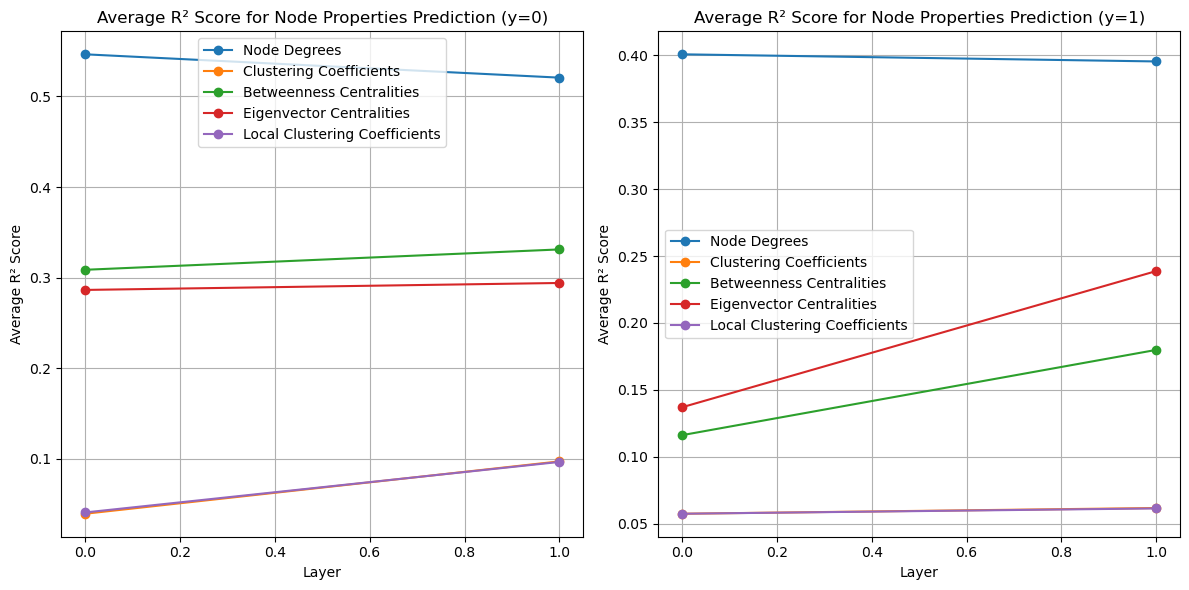

In [22]:
# Separate the graphs based on labels
def separate_graphs_by_label(features, properties, labels):
    features_0, properties_0, features_1, properties_1 = [], [], [], []
    
    for i, graph in enumerate(gnn.dataset[gnn.train_idx]):
        if graph.y.item() == 0:
            features_0.append(features[i])
            properties_0.append(properties[i])
        else:
            features_1.append(features[i])
            properties_1.append(properties[i])
    
    return features_0, properties_0, features_1, properties_1

train_features_0, train_properties_0, train_features_1, train_properties_1 = separate_graphs_by_label(train_features, train_node_properties, gnn.dataset[gnn.train_idx])

# Prepare the data for linear regression model training
def prepare_regression_data(features, properties, property_index):
    X_layers = [[] for _ in range(len(features[0]))]
    y_layers = [[] for _ in range(len(features[0]))]

    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            for node_index in range(len(graph_features[layer])):
                X_layers[layer].append(graph_features[layer][node_index])
                y_layers[layer].append(properties[i][property_index][node_index])

    X_layers = [torch.tensor(X) for X in X_layers]
    y_layers = [torch.tensor(y) for y in y_layers]
    
    return X_layers, y_layers

# Training and evaluating linear regression models for each layer
def train_and_evaluate_regression(X_layers, y_layers):
    r2_scores = []
    
    for layer in range(len(X_layers)):
        X = X_layers[layer]
        y = y_layers[layer]
        
        model = LinearModel(X.shape[1], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Train the model
        model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            outputs = model(X.float())
            loss = criterion(outputs, y.float().view(-1, 1))
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions = model(X.float()).view(-1)
            r2 = r2_score(y.float(), predictions)
        r2_scores.append(r2)
    
    return r2_scores

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients

properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store R² scores
r2_scores_0 = {name: [] for name in property_names}
r2_scores_1 = {name: [] for name in property_names}

# Compute R² scores for graphs with y=0
for prop_idx, prop_name in zip(properties_indices, property_names):
    X_layers, y_layers = prepare_regression_data(train_features_0, train_properties_0, prop_idx)
    r2_scores_0[prop_name] = train_and_evaluate_regression(X_layers, y_layers)

# Compute R² scores for graphs with y=1
for prop_idx, prop_name in zip(properties_indices, property_names):
    X_layers, y_layers = prepare_regression_data(train_features_1, train_properties_1, prop_idx)
    r2_scores_1[prop_name] = train_and_evaluate_regression(X_layers, y_layers)

# Plot the results
layers = np.arange(len(r2_scores_0[property_names[0]]))

plt.figure(figsize=(12, 6))

# Plot for graphs with y=0
plt.subplot(1, 2, 1)
for prop_name in property_names:
    plt.plot(layers, r2_scores_0[prop_name], label=prop_name, marker='o')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction (y=0)')
plt.legend()
plt.grid(True)

# Plot for graphs with y=1
plt.subplot(1, 2, 2)
for prop_name in property_names:
    plt.plot(layers, r2_scores_1[prop_name], label=prop_name, marker='o')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction (y=1)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##### Probing for the top 1 nodes with diagnostic classifier trained on the train set and test on the test set

Processing property: Node Degrees
Processing property: Clustering Coefficients
Processing property: Betweenness Centralities
Processing property: Eigenvector Centralities
Processing property: Local Clustering Coefficients


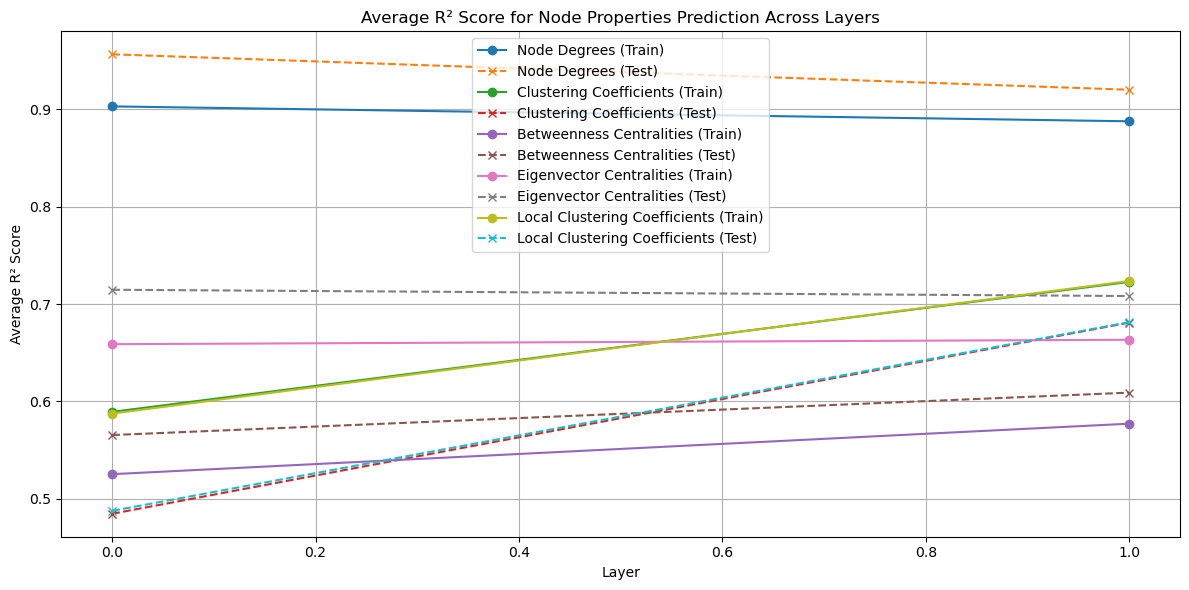

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Define Linear Model for probing (diagnostic classifier)
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Prepare the data for probing classifier
def prepare_regression_data(features, properties, property_index, top_n_nodes=1):
    X_layers = [[] for _ in range(len(features[0]))]
    y_layers = [[] for _ in range(len(features[0]))]

    for i, graph_features in enumerate(features):
        top_nodes_indices = get_top_nodes(properties[i][property_index], top_n=top_n_nodes)
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices:
                X_layers[layer].append(graph_features[layer][node_index])
                y_layers[layer].append(properties[i][property_index][node_index])

    X_layers = [torch.tensor(X) for X in X_layers]
    y_layers = [torch.tensor(y) for y in y_layers]
    
    return X_layers, y_layers

# Train and evaluate the probing classifier for each layer
def train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers):
    r2_scores_train = []
    r2_scores_test = []
    
    for layer in range(len(X_train_layers)):
        X_train = X_train_layers[layer]
        y_train = y_train_layers[layer]
        X_test = X_test_layers[layer]
        y_test = y_test_layers[layer]
        
        model = LinearModel(X_train.shape[1], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Train the model
        model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            outputs = model(X_train.float())
            loss = criterion(outputs, y_train.float().view(-1, 1))
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions_train = model(X_train.float()).view(-1)
            predictions_test = model(X_test.float()).view(-1)
            r2_train = r2_score(y_train.float(), predictions_train)
            r2_test = r2_score(y_test.float(), predictions_test)
        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)
    
    return r2_scores_train, r2_scores_test

# Aggregate R² scores across all graphs
def aggregate_r2_scores(features_train, properties_train, features_test, properties_test, property_index):
    X_train_layers, y_train_layers = prepare_regression_data(features_train, properties_train, property_index)
    X_test_layers, y_test_layers = prepare_regression_data(features_test, properties_test, property_index)
    
    r2_scores_train, r2_scores_test = train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers)
    
    return r2_scores_train, r2_scores_test

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients
properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store average R² scores across all layers
avg_r2_train_dict = {name: [] for name in property_names}
avg_r2_test_dict = {name: [] for name in property_names}

# Train and evaluate the probing classifier for each property
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property: {prop_name}")
    avg_r2_train_dict[prop_name], avg_r2_test_dict[prop_name] = aggregate_r2_scores(train_features, train_node_properties, test_features, test_node_properties, prop_idx)

# Plotting the average R² scores across layers for each property
layers = np.arange(len(avg_r2_train_dict[property_names[0]]))

plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

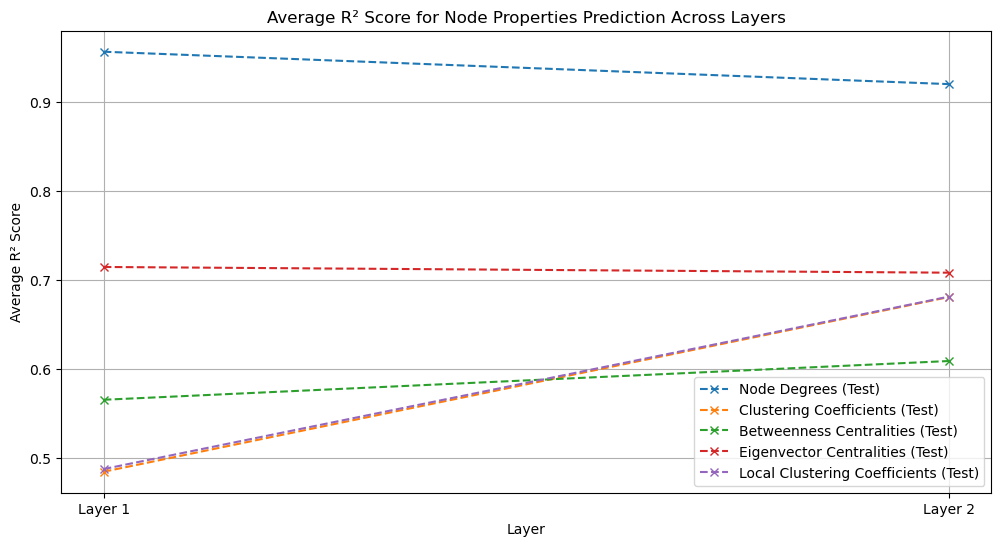

In [24]:
#plot only test results
plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
#x axis called layer 1, layer 2, etc
plt.xticks(range(len(layers)), [f'Layer {i+1}' for i in layers])           
plt.grid(True)